# Imports and library functions

In [1]:
from dataclasses import dataclass
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import plot_tree
from ydata_profiling import ProfileReport

from lib.chartSpecificData import survivalFrame
from lib.clean import cleanAge, cleanEmbarked, cleanFare, dropIrrelevant
from lib.featureEngineering import addFamilyCountData
from lib.numericConversion import (SexConversion, embarkedConverter,
                                   sexConverter)

### matplotlib options

This is just because my local setup is weird

In [2]:
matplotlib.use("ipympl")
plt.ioff()

## Compose
a function that enables functional composition
compose :: function, function, ... -> function

compose(f, g, h, i)(x) is equivalent to i(h(g(f(x))))

In [3]:
def compose(*funcs):
    return reduce(lambda f, g: lambda x: g(f(x)), funcs, lambda x: x)

## Import The Data

In [4]:

data: DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv"
)

## Data Exploration part 1

### Get the first few rows

In [5]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Get the last few rows

In [6]:
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### Get summary, data types, that sort of thing

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Get descriptive statistics

In [8]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Get number of nulls

In [9]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### ydataprofiler

In [10]:
# ProfileReport(data, title="Titanic Profiling Report")

# Data Preprocessing

Here we are just getting rid of null values and dropping irrelevant data that we don't need

In [11]:
cleanData = compose(cleanAge, cleanFare, cleanEmbarked, dropIrrelevant)
convertDataToNumeric = compose(sexConverter, embarkedConverter)

processedData = compose(cleanData, convertDataToNumeric)(data)
processedDataRows = len(processedData)

# Data Exploration Part II and Data Visualization

### ydata profiler again because catagorical data sucks

In [12]:
# ProfileReport(processedData, title="Titanic Profiling Report")

### Correlation Graph

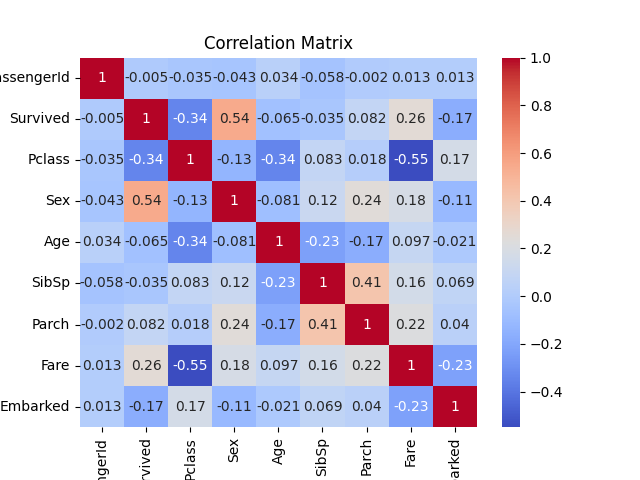

In [13]:
processedDataCorrMatrix = processedData.corr().round(3)
sns.heatmap(processedDataCorrMatrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Survival by Sex

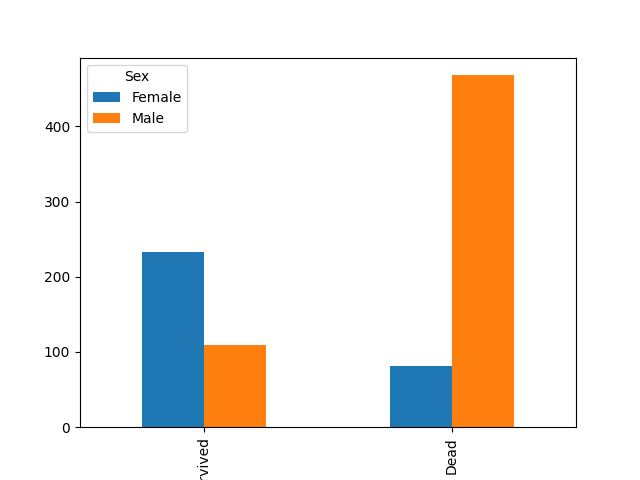

In [14]:

survivalFrame("Sex", processedData).rename(columns={1: "Female", 0: "Male"}).plot.bar()
plt.show()

Survival by class

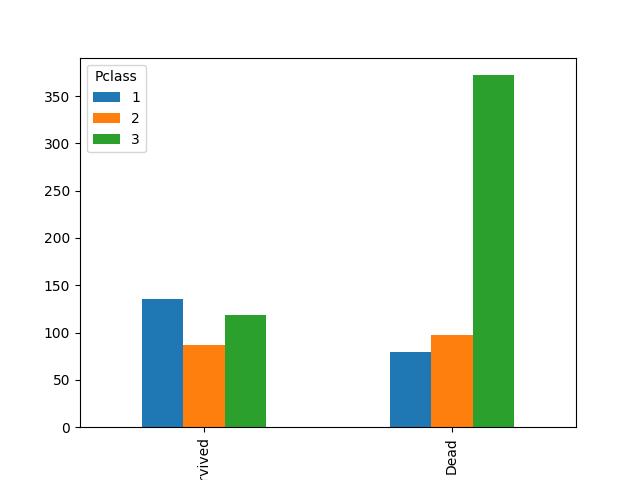

In [15]:
pclass = survivalFrame("Pclass", processedData).sort_index(axis=1)
pclass.plot.bar()
plt.show()

Survival by age

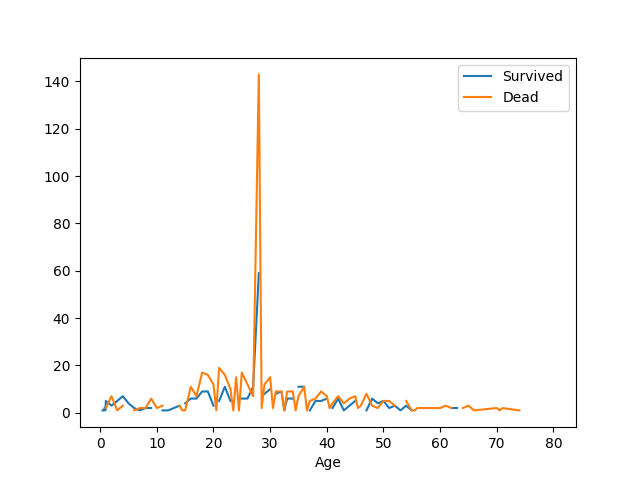

In [16]:
survivalFrame("Age", processedData).sort_index(axis=1).transpose().plot.line()
plt.show()

Survival of women by age

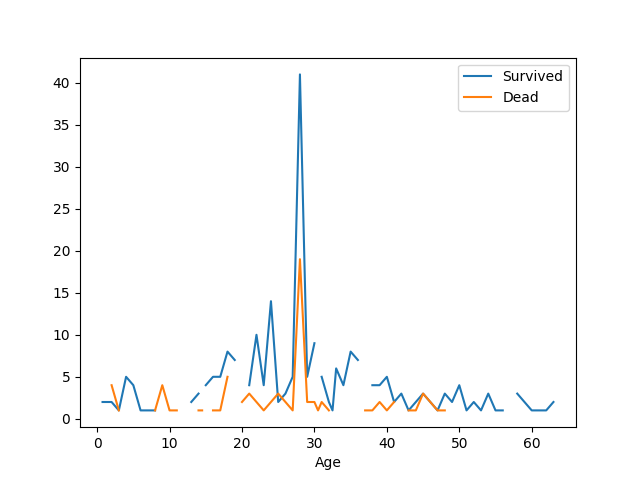

In [17]:
survivalFrame("Age", processedData[processedData["Sex"] == 1]).sort_index(
    axis=1
).transpose().plot.line()
plt.show()

Survival of men by age

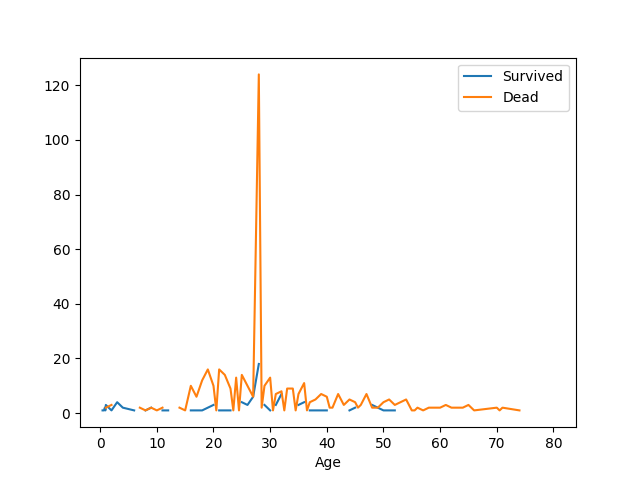

In [18]:
survivalFrame("Age", processedData[processedData["Sex"] == 0]).sort_index(
    axis=1
).transpose().plot.line()
plt.show()

Survival of children by age

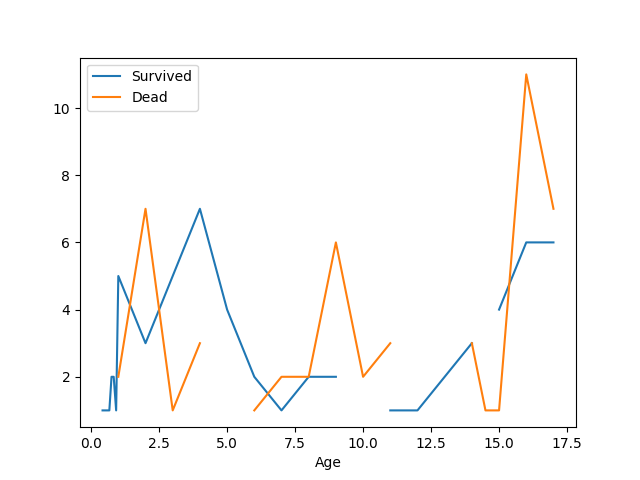

In [19]:
survivalFrame("Age", processedData[processedData["Age"] < 18]).sort_index(
    axis=1
).transpose().plot.line()
plt.show()

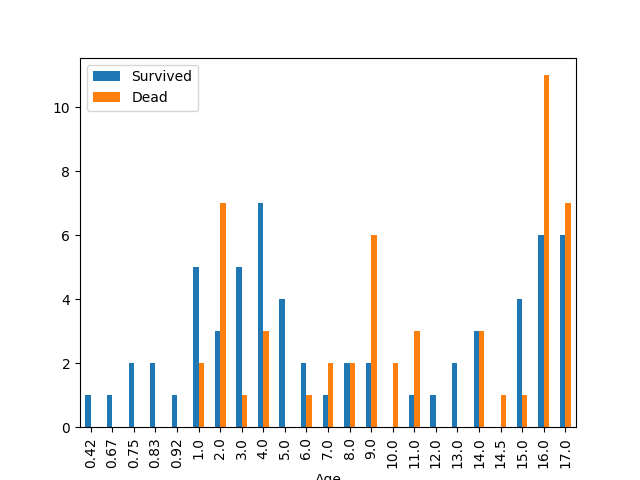

In [20]:
survivalFrame("Age", processedData[processedData["Age"] < 18]).sort_index(
    axis=1
).transpose().plot.bar()
plt.show()

Total survival of all children

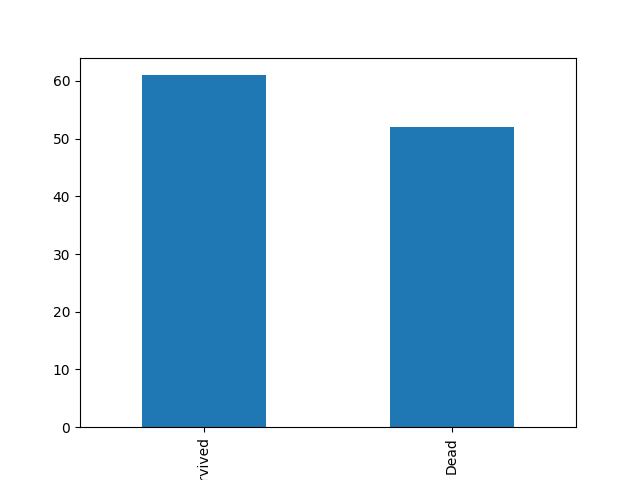

In [21]:
survivalFrame("Age", processedData[processedData["Age"] < 18]).sort_index(
    axis=1
).transpose().sum().plot.bar()
plt.show()

In [22]:
survivalFrame("Age", processedData[processedData["Age"] < 18]).sort_index(
    axis=1
).transpose().sum()

Survived    61.0
Dead        52.0
dtype: float64

The obvious conclusion is that being a child doesn't help your chancesa all that much

In [23]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [24]:
processedData

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,2.0
1,2,1,1,1,38.0,1,0,71.2833,0.0
2,3,1,3,1,26.0,0,0,7.9250,2.0
3,4,1,1,1,35.0,1,0,53.1000,2.0
4,5,0,3,0,35.0,0,0,8.0500,2.0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,2.0
887,888,1,1,1,19.0,0,0,30.0000,2.0
888,889,0,3,1,28.0,1,2,23.4500,2.0
889,890,1,1,0,26.0,0,0,30.0000,0.0


## Machine learning

### Random Forest

In [25]:
X = processedData.drop(["Survived"], axis=1)
y = processedData["Survived"]
randomState = 42

# splitting up the dataset for teesting
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=randomState
)
randomForest = RandomForestClassifier(n_estimators=100, random_state=randomState)
randomForest.fit(X_train, y_train)

y_pred = randomForest.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8268156424581006


### Fine Tuning

In [29]:
paramGrid = {
    "n_estimators": [100, 200, 300],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 6, 8, 10],
    "criterion": ["gini", "entropy"],
}
gridSearch = GridSearchCV(
    estimator=randomForest, param_grid=paramGrid, cv=5, n_jobs=3, scoring="accuracy"
)
gridSearch.fit(X_train, y_train)

bestParams = gridSearch.best_params_

print(f"bestParams: {bestParams}")
# create new model with better parameters
randomForest2 = gridSearch.best_estimator_
# fit the model
randomForest2.fit(X_train, y_train)
y_pred = randomForest2.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")

/home/zack/development/ieeeDataScience/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zack/development/ieeeDataScience/env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zack/development/ieeeDataScience/env/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/zack/development/ieeeDataScience/env/lib/python3.12/site-packages/sklearn/base.py",

bestParams: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 100}
Accuracy: 0.8156424581005587


### visualize the model

In [ ]:
tree = randomForest.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=True,
    filled=True,
    fontsize=6,
    rounded=True,
)
plt.show()

In [ ]:
testPassenger = pd.DataFrame.from_dict(
    {
        "PassengerId": [1],
        "Pclass": [1],
        "Sex": [1],
        "Age": [42],
        "SibSp": [1],
        "Parch": [0],
        "Fare": [30],
        "Embarked": [2],
    }
)
testPassengerPrediction = randomForest.predict(testPassenger)
print(testPassengerPrediction)